# Классификация sms сообщений

In [1]:
%matplotlib inline

В этом задании мы будем использовать данные SMS Spam collection из репозитория UCI.
Файл с данными расположен [по ссылке](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/)

### Загрузка, визуализация и предварительный анализ данных

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("SMSSpamCollection", \
                  sep="\t", \
                  header=None, \
                  names=["label", "sms"])

In [4]:
data.head(10)

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


В первом столбце хранятся метки (спам или не спам), во втором - текст сообщения.

Посмотрим, сколько всего объектов:

In [5]:
len(data)

5572

Посмотрим, сколько объектов каждого класса:

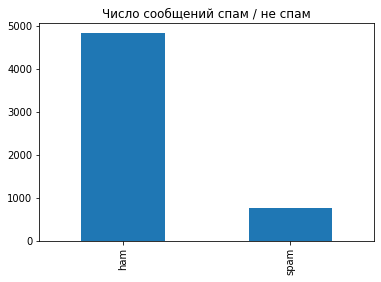

In [6]:
counts = data["label"].value_counts()
counts.plot(kind='bar', title="Число сообщений спам / не спам")

In [7]:
counts

ham     4825
spam     747
Name: label, dtype: int64

В выборке гораздо больше не-спама, чем спама.

### Предобработка данных

В данных пока что нет выделенных признаков. Для текстов можно использовать простое преобразование -- "мешок слов". Создадим словарь из всех слов, которые встречаются в sms. Для каждого объекта-текста мы получим столько признаков, сколько слов в словаре, и каждый признак содержит 1 (слово входит в текст) или 0 (слово не входит).

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(data["sms"])

In [10]:
# слова в том порядке, в котором они идут в матрице X по столбцам
words = pd.Series(vectorizer.vocabulary_).sort_values().index
words

Index(['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236',
       '01223585334', '0125698789', '02',
       ...
       'zhong', 'zindgi', 'zoe', 'zogtorius', 'zoom', 'zouk', 'zyada', 'èn',
       'ú1', '〨ud'],
      dtype='object', length=8713)

In [11]:
X.shape #количество объектов и признаков

(5572, 8713)

In [12]:
X[:5].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Мы почти не видим единиц в этой матрице, потому что их очень мало.

У нас есть еще одна небольшая проблема: классы обозначены не числами, а буквами. Перекодируем "spam" в 1, а "ham" в 0

In [13]:
y=data.replace({'label':{'spam':1,'ham':0}})['label']
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

Разделим данные на обучение и контроль в пропорции 3:1:

In [14]:
from sklearn.model_selection import train_test_split

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Обучение линейной модели

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model1 = LogisticRegression().fit(X_train,y_train)
y_pred1 = model1.predict(X_test)
y_pred2 = model1.predict(X_train)

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [62]:
#Выводим топ-100 самых высоких значений коэффициентов и топ-100 самых маленьких
frame = pd.DataFrame({'Words': words, 'Coef': model1.coef_[0]}).sort_values('Coef', ascending = False)
print(frame[:100],frame[-101:-1], sep="\n")

         Words      Coef
7986       txt  2.138644
6525  ringtone  1.820219
7644      text  1.709394
8016        uk  1.566381
1828      call  1.502064
...        ...       ...
4149      info  0.558154
6340   receive  0.556211
4419       ken  0.554790
1399    barbie  0.554790
8301     wanna  0.554273

[100 rows x 2 columns]
       Words      Coef
7709   think -0.275098
5894   place -0.277838
5379   night -0.278671
5565     one -0.280792
6895  should -0.287774
...      ...       ...
2163    come -0.677521
1066      am -0.737493
4793      lt -1.000472
5254      my -1.029380
3684      gt -1.041148

[100 rows x 2 columns]


Можно сказать, что топ-слова действительно характеризуют каждый из двух классов. Наибольшие коэффициенты получили преимущественно слова без сокращений, требующие реакции от пользователя ("text","call","receive"). Такие слова часто используются в спам-сообщениях. Наименьшие коэффициенты получили слова, являющиеся слэнговыми сокращениями, чаще используемые в переписках пользователей

### Оценивание качества

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_test, y_pred1)

0.9863603732950467

In [21]:
accuracy_score(y_train, y_pred2)

0.9978463747307968

Поскольку в данных класс 1 редкий, лучше использовать точность и полноту

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [23]:
precision_score(y_test,y_pred1)

0.9945054945054945

In [24]:
recall_score(y_test,y_pred1)

0.9095477386934674

In [25]:
f1_score(y_test,y_pred1)

0.9501312335958007

Почти все, что алгоритм отнес к спамовым смс-сообщениям, действительно является спамом. Однако алгоритм находит не все спамовые сообщения. Precision_score составила 0,99 => 99% сообщений, отнесенных моделью к спаму,действительно таковыми являются.  Recall_score составила 0,9 => 90% сообщений, являющихся спамом, были отнесены моделью к таковым. Следовательно, модель находит не все спамовые сообщения, но редко совершает ошибку, причисляя неспамовые к спамовым.

Построим ROC-кривую для обученной модели

In [26]:
from sklearn.metrics import roc_curve

In [27]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'ROC-curve')

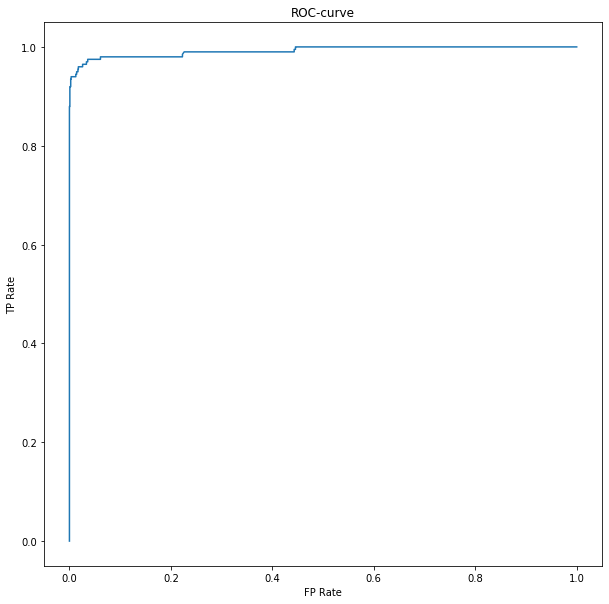

In [67]:
#испоьзуем функцию predict_proba
#она вернет матрицу размера (число объектов, 2), для каждого объекта - вероятность класса 0 и вероятность класса 1
y_probas = model1.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, y_probas)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC-curve")

### Подбор гиперпараметра - коэффициента регуляризации

В наших данных очень много признаков - столько, сколько слов с словаре. Следовательно, стоит применить L1 регуляризацию, чтобы отобрать релевантные признаки.

In [29]:
import numpy as np

В модели без регуляризации доля нулевых весов составила 14.2%

In [68]:
(np.sum(model1.coef_==0)/model1.coef_.shape[1])*100

14.220130838976242

In [31]:
model2 = LogisticRegression(penalty="l1").fit(X,y)

В модели с L1 регуляризацией 97.5% нулевых весов

In [69]:
(np.sum(model2.coef_==0)/model2.coef_.shape[1])*100

97.53242281648113

Теперь подберем коэффициент регуляризации в помощью кросс-валидации. Для этого воспользуемся GridSearchCV:

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
model_for_gs = model2
param_grid = np.array([10**n for n in range(10)])
gs = GridSearchCV(model_for_gs, \
                   {"C":param_grid}, \
                   verbose=3)

In [42]:
model3 = gs.fit(X_train,y_train).best_estimator_
y_pred3 = model3.predict(X_test)

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.972, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.966, total=   0.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.984, total=   0.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.971, total=   0.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.966, total=   0.0s
[CV] C=100 ...........................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s finished


Построим график коэффициент регуляризации - качество:

Text(0, 0.5, 'accuracy')

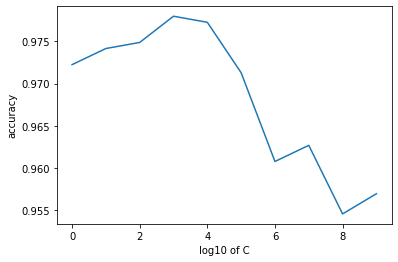

In [40]:
cs = np.log10([elem for elem in gs.cv_results_['param_C']])
quals = [elem for elem in gs.cv_results_['mean_test_score']]
plt.plot(cs, quals)

plt.xlabel("log10 of C")
plt.ylabel("accuracy")

Оптимальное C - 1000
Что очень большие, что очень маленькие C ведут к уменьшению показателя accuracy, то есть снижают долю правильных ответов из-за слишком слабой или слишком сильной регуляризации

В модели с оптимальным коэффициентом регуляризации C доля нулевых весов составила 92.6%

In [38]:
np.sum(model3.coef_==0)/model3.coef_.shape[1]

0.9260874555262252

Оценим качество модели

In [39]:
quality = {"Accuracy":accuracy_score(y_test,y_pred3), \
           "Precision":precision_score(y_test,y_pred3), \
           "Recall": recall_score(y_test,y_pred3), \
           "f1": f1_score(y_test,y_pred3)}
    
quality

{'Accuracy': 0.9842067480258435,
 'Precision': 0.994413407821229,
 'Recall': 0.8944723618090452,
 'f1': 0.9417989417989417}

В сравнении между разреженной и неразреженной моделями уменьшились precision и recall, что означает, что теперь модель пропускает больше позитивных значений, одновременно увеличивая количество false positives. Можно сделать вывод, что данная модель хуже классифицирует письма на относящиеся к спаму и являющиеся аутентичными пользовательскими сообщениями